In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import cv2

IMG_SIZE = 128
BASE_DIR = '/content/drive/MyDrive/CattleImageRepository'

def load_and_preprocess_data(base_dir, subdirs):
    X, y = [], []

    x_dirs = ['X', 'x1_files', 'x2_files', 'x3_files', 'x4_files', 'X']
    y_dirs = ['Y', 'y1_files', 'y2_files', 'y3_files', 'y4_files', 'y']

    for subdir in subdirs:

        counter = 0

        full_path = os.path.join(base_dir, *subdir.split('/'))

        x_dir, y_dir = None, None

        for x_subdir, y_subdir in zip(x_dirs, y_dirs):
            test_x_dir = os.path.join(full_path, x_subdir)
            test_y_dir = os.path.join(full_path, y_subdir)
            if os.path.isdir(test_x_dir) and os.path.isdir(test_y_dir):
                x_dir, y_dir = test_x_dir, test_y_dir
                break

        if x_dir and y_dir:
            x_files = [f for f in os.listdir(x_dir) if f.endswith(('x.png', 'x1.png', 'x.jpeg', 'x1.jpeg'))]

            for x_file in x_files:
                y_file = x_file.replace('x.', 'y.').replace('x1.', 'y1.')
                y_path = os.path.join(y_dir, y_file)
                if os.path.exists(y_path):
                    x_path = os.path.join(x_dir, x_file)
                    img = cv2.imread(x_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    X.append(img)

                    mask = cv2.imread(y_path)
                    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
                    y.append(mask)

                    counter += 1

            print(f"{subdir}: {counter} imagens processadas.")
        else:
            print(f"Erro: Pastas 'X' ou 'Y/y' não encontradas em {subdir}")

    return np.array(X), np.array(y)

subdirs = [
    'G1/01-08-2024', 'G1/08-08-2024',
    'G2/29-07/00000000196000500', 'G2/29-07/00000000196000400',
    'G2/06-08/Video_1', 'G2/06-08/Video_2',
    'G3/30-07/termica', 'G4/02-08'
]

X, y = load_and_preprocess_data(BASE_DIR, subdirs)
X = np.expand_dims(X, axis=-1)
y = np.expand_dims(y, axis=-1)

G1/01-08-2024: 580 imagens processadas.
G1/08-08-2024: 613 imagens processadas.
G2/29-07/00000000196000500: 218 imagens processadas.
G2/29-07/00000000196000400: 268 imagens processadas.
G2/06-08/Video_1: 771 imagens processadas.
G2/06-08/Video_2: 63 imagens processadas.
G3/30-07/termica: 607 imagens processadas.
G4/02-08: 830 imagens processadas.


(128, 128, 3)


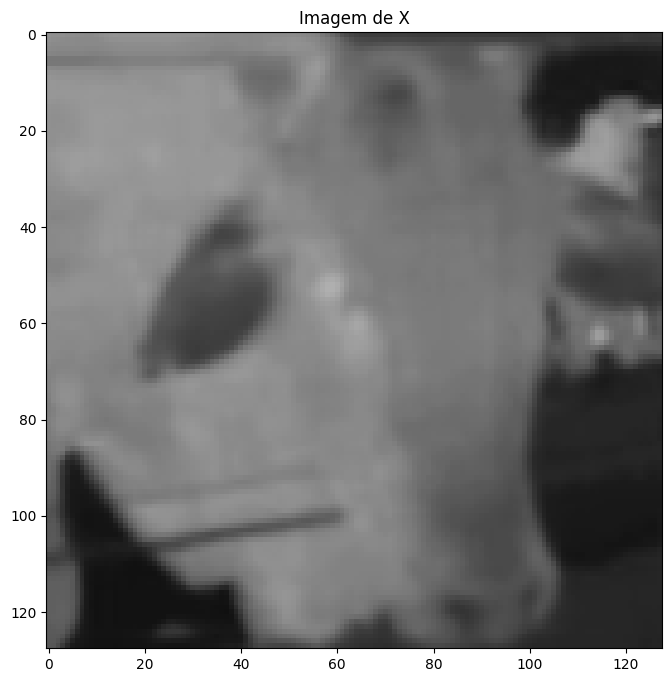

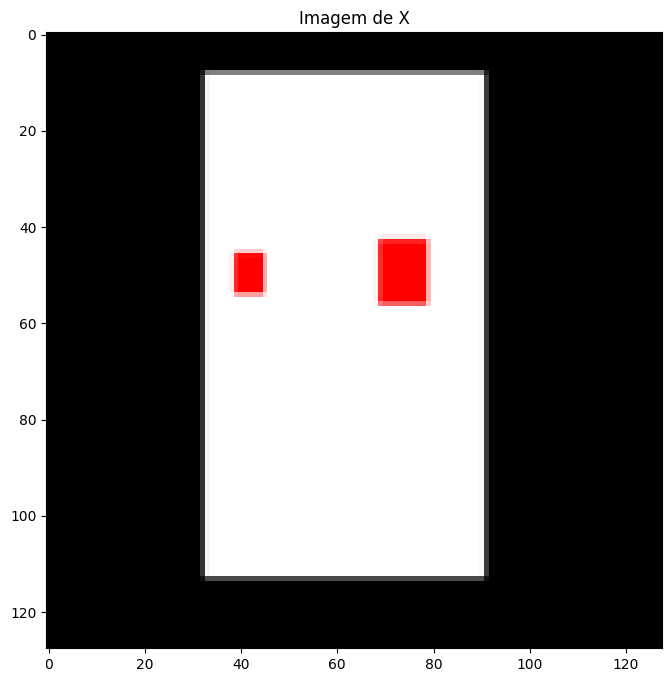

In [3]:
import matplotlib.pyplot as plt

image = X[np.random.randint(0, X.shape[0])]
image2= y[np.random.randint(0, y.shape[0])]

if image.shape[-1] == 1:
    image = image.squeeze()

if image2.shape[-1] == 1:
    image2 = image2.squeeze()

print(image.shape)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f'Imagem de X')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(image2)
plt.title(f'Imagem de X')
plt.show()

In [4]:
X.shape, y.shape

((3950, 128, 128, 3, 1), (3950, 128, 128, 3, 1))

In [178]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

In [179]:
print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de y_test:", y_test.shape)

Shape de X_train: (3160, 128, 128, 3, 1)
Shape de X_test: (790, 128, 128, 3, 1)
Shape de y_train: (3160, 128, 128, 3, 1)
Shape de y_test: (790, 128, 128, 3, 1)


In [180]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

def apply_data_augmentation(X, y, variations=2):

    X_augmented = []
    y_augmented = []

    datagen = ImageDataGenerator(
        rotation_range=5,
        zoom_range=0.2,
        width_shift_range=0.05,
        height_shift_range=0.05,
        brightness_range=[0.8, 1.2],
        channel_shift_range=50,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest'
    )

    for i in range(X.shape[0]):

        image = X[i]
        mask = y[i]

        if image.ndim == 4:
            image = image.squeeze()
        if mask.ndim == 4:
            mask = mask.squeeze()

        X_augmented.append(image)
        y_augmented.append(mask)

        for j in range(variations):
            params = datagen.get_random_transform(image.shape)

            augmented_image = datagen.apply_transform(image, params)
            augmented_mask = datagen.apply_transform(mask, params)

            X_augmented.append(augmented_image)
            y_augmented.append(augmented_mask)

    return np.array(X_augmented), np.array(y_augmented)

X_train_augmented, y_train_augmented = apply_data_augmentation(X_train, y_train)

In [181]:
X_train_augmented = X_train_augmented / 255.0
y_train_augmented = y_train_augmented / 255.0

X_test = X_test / 255.0
y_test = y_test / 255.0

In [182]:
X_test = X_test.squeeze()
y_test = y_test.squeeze()

In [183]:
X_train_augmented.shape, y_train_augmented.shape

((9480, 128, 128, 3), (9480, 128, 128, 3))

In [184]:
X_test.shape, y_test.shape

((790, 128, 128, 3), (790, 128, 128, 3))

(-0.5, 127.5, 127.5, -0.5)

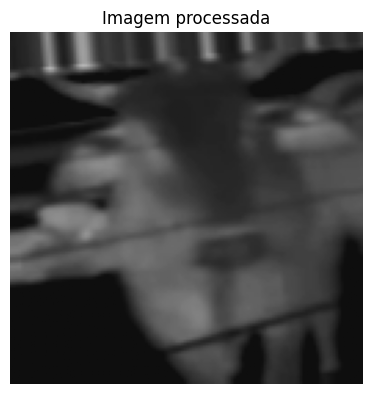

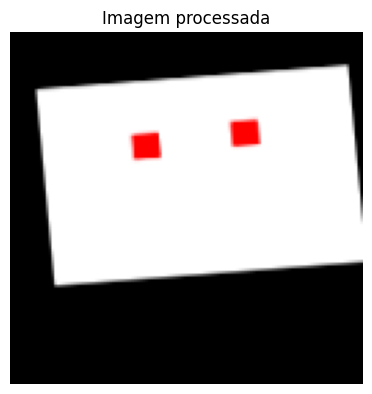

In [252]:
index = np.random.randint(0, X_train_augmented.shape[0])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train_augmented[index])
plt.title("Imagem processada")
plt.axis('off')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(y_train_augmented[index])
plt.title("Imagem processada")
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

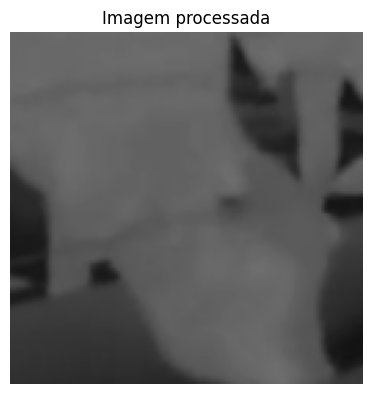

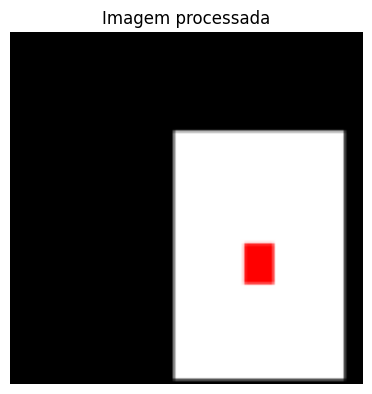

In [186]:
index = np.random.randint(0, X_test.shape[0])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_test[index])
plt.title("Imagem processada")
plt.axis('off')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(y_test[index])
plt.title("Imagem processada")
plt.axis('off')

In [195]:
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm

def reduce_colors(img_array, colors):
    assert img_array.shape == (128, 128, 3), "Input array must have shape (128, 128, 3)"
    fixed_colors = np.array(colors)
    pixels = img_array.reshape(-1, 3)
    distances = np.sqrt(((pixels[:, np.newaxis, :] - fixed_colors) ** 2).sum(axis=2))
    nearest_color_indices = distances.argmin(axis=1)
    new_img = fixed_colors[nearest_color_indices].reshape(img_array.shape)
    return (new_img * 255).astype('uint8')

def reduce_colors_dataset(dataset, colors):
    return np.array([reduce_colors(img, colors) for img in tqdm(dataset, desc="Processing images")])

In [196]:
colors = [
    (1.0, 1.0, 1.0),  # White
    (1.0, 0.0, 0.0),  # Red
    (0.0, 0.0, 0.0)   # Black
]

y_train_reduced = reduce_colors_dataset(y_train_augmented, colors)
y_test_reduced = reduce_colors_dataset(y_test, colors)

Processing images: 100%|██████████| 790/790 [00:02<00:00, 391.48it/s]


In [197]:
import numpy as np
import cv2
from PIL import Image, ImageEnhance
def process_images(X_train, X_test):

    def apply_clahe(image):
        image_gray = (image * 255).astype(np.uint8)
        image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(2, 2))
        image_clahe = clahe.apply(image_gray)
        image_clahe_rgb = cv2.cvtColor(image_clahe, cv2.COLOR_GRAY2RGB)
        return image_clahe_rgb / 255.0

    def adjust_contrast(image, factor):
        image_pil = Image.fromarray((image * 255).astype(np.uint8))
        enhancer = ImageEnhance.Contrast(image_pil)
        image_pil = enhancer.enhance(factor)
        return np.array(image_pil) / 255.0

    def process_single_image(image):
        clahe_image = apply_clahe(image)
        adjusted_image = adjust_contrast(clahe_image, 1.5)
        return adjusted_image

    X_train_processed = np.array([process_single_image(img) for img in X_train])
    X_test_processed = np.array([process_single_image(img) for img in X_test])

    return X_train_processed, X_test_processed

In [198]:
X_train_processed, X_test_processed = process_images(X_train_augmented.copy(), X_test.copy())

In [238]:
vgg16_path = '/content/drive/MyDrive/VGG_TransferLearning_V2TOP_SEMOVERFITTING.h5'
try:
    vgg16 = load_model(vgg16_path, compile=False)
    print("VGG16 model loaded successfully")
except Exception as e:
    print(f"Error loading VGG16 model: {e}")
    raise

VGG16 model loaded successfully


In [281]:
min_samples = min(X_train.shape[0], y_train.shape[0])

val_split = 0.2
val_samples = int(min_samples * val_split)
X_val = X_train_processed[-val_samples:]
y_val = y_train_reduced[-val_samples:]
X_train = X_train_processed[:-val_samples]
y_train = y_train_reduced[:-val_samples]

In [282]:
X_train.shape, y_train.shape

((7943, 128, 128, 3), (7943, 128, 128, 3))

In [283]:
X_val.shape, y_val.shape

((1537, 128, 128, 3), (1537, 128, 128, 3))

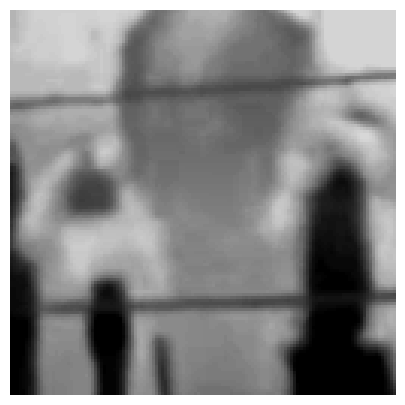

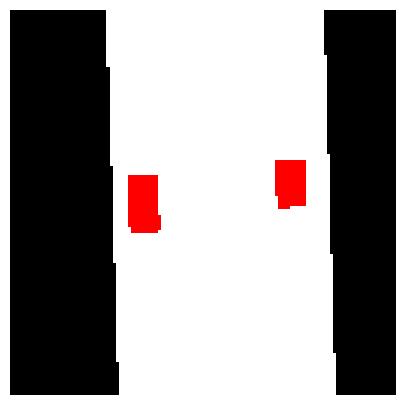

In [284]:
index_random = np.random.randint(0, X_test_processed.shape[0])

plt.figure(figsize=(10, 5))
plt.imshow(X_train[index_random], cmap=plt.cm.gray)
plt.axis('off')
plt.show(block=False)
plt.close()

plt.figure(figsize=(10, 5))
plt.imshow(y_train[index_random], cmap=plt.cm.gray)
plt.axis('off')
plt.show(block=False)
plt.close()

In [335]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
import numpy as np

import tensorflow as tf
import tensorflow.keras.backend as K

def simple_segmentation_loss(y_true, y_pred):
    def dice_loss(y_true, y_pred, smooth=1):
        intersection = K.sum(y_true * y_pred, axis=[1,2,3])
        union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
        dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
        return 1 - dice

    def binary_crossentropy(y_true, y_pred):
        return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

    # Combine Dice Loss and Binary Cross-Entropy
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * binary_crossentropy(y_true, y_pred)

# Load the VGG16 model
vgg16_path = '/content/drive/MyDrive/VGG_TransferLearning_V2TOP_SEMOVERFITTING.h5'
try:
    vgg16 = load_model(vgg16_path, compile=False)
    print("VGG16 model loaded successfully")
    print("VGG16 input shape:", vgg16.input_shape)
    print("VGG16 output shape:", vgg16.output_shape)
except Exception as e:
    print(f"Error loading VGG16 model: {e}")
    raise

def simplified_unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    vgg16 = load_model(vgg16_path, compile=False)

    # Encoder (use VGG16 layers)
    x = vgg16.get_layer('block1_conv1')(inputs)
    x = vgg16.get_layer('block1_conv2')(x)
    skip1 = x
    x = MaxPooling2D()(x)

    x = vgg16.get_layer('block2_conv1')(x)
    x = vgg16.get_layer('block2_conv2')(x)
    skip2 = x
    x = MaxPooling2D()(x)

    x = vgg16.get_layer('block3_conv1')(x)
    x = vgg16.get_layer('block3_conv2')(x)
    x = vgg16.get_layer('block3_conv3')(x)
    skip3 = x
    x = MaxPooling2D()(x)

    x = vgg16.get_layer('block4_conv1')(x)
    x = vgg16.get_layer('block4_conv2')(x)
    x = vgg16.get_layer('block4_conv3')(x)
    skip4 = x
    x = MaxPooling2D()(x)

    x = vgg16.get_layer('block5_conv1')(x)
    x = vgg16.get_layer('block5_conv2')(x)
    x = vgg16.get_layer('block5_conv3')(x)

    # Decoder
    x = UpSampling2D()(x)
    x = concatenate([x, skip4])
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)

    x = UpSampling2D()(x)
    x = concatenate([x, skip3])
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)

    x = UpSampling2D()(x)
    x = concatenate([x, skip2])
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)

    x = UpSampling2D()(x)
    x = concatenate([x, skip1])
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Dropout(0.1)(x)

    outputs = Conv2D(3, 1, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = simplified_unet()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=simple_segmentation_loss,
              metrics=['accuracy'])

model.summary()

# Verify and preprocess data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=25,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('unet_boi_olhos_vgg16_v1.2.keras', save_best_only=True, monitor='val_loss')
    ]
)

model.save('unet_boi_olhos_vgg16_v1.2.h5')
print("Model saved successfully")

VGG16 model loaded successfully
VGG16 input shape: (None, 128, 128, 3)
VGG16 output shape: (None, 128, 128, 3)


Model: "functional_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_74            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 128, 128, 64)   │          1,792 │ input_layer_74[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 128, 128, 64)   │         36,928 │ block1_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_210         │ (None, 64, 64, 64)     │              0 │ block1_conv2[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_210[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 64, 64, 128)    │        147,584 │ block2_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_211         │ (None, 32, 32, 128)    │              0 │ block2_conv2[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_211[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_212         │ (None, 16, 16, 256)    │              0 │ block3_conv3[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_212[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_213         │ (None, 8, 8, 512)      │              0 │ block4_conv3[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ max_pooling2d_213[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block5_conv1[1][0]     │
├──────────────────────

 Total params: 24,891,267 (94.95 MB)

 Trainable params: 24,891,267 (94.95 MB)

 Non-trainable params: 0 (0.00 B)

X_train shape: (7943, 128, 128, 3)
y_train shape: (7943, 128, 128, 3)
Epoch 1/25
249/249 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.4439 - loss: 34.9029 - val_accuracy: 0.9537 - val_loss: 31.8451 - learning_rate: 1.0000e-04
Epoch 2/25
249/249 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9367 - loss: 31.5531 - val_accuracy: 0.9710 - val_loss: 31.9083 - learning_rate: 1.0000e-04
Epoch 3/25
249/249 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9699 - loss: 30.6246 - val_accuracy: 0.9704 - val_loss: 31.3570 - learning_rate: 1.0000e-04
Epoch 4/25
249/249 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9741 - loss: 30.1949 - val_accuracy: 0.9835 - val_loss: 31.3624 - learning_rate: 1.0000e-04
Epoch 5/25
249/249 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9788 - loss: 29.8978 - val_accuracy: 0.9855 - val_loss: 31.2324 - learning_rate: 1.0000e-04
Epoch 6/25
249/249 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9830 - loss: 29.3015 - val_accuracy: 0.9886 - val_loss: 31.208

Model saved successfully


In [336]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

# Definindo as funções personalizadas
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * tf.keras.losses.mean_squared_error(y_true, y_pred)

# Definindo a função de perda personalizada 'loss'
def loss(y_true, y_pred):
    return combined_loss(y_true, y_pred)

y_pred = model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


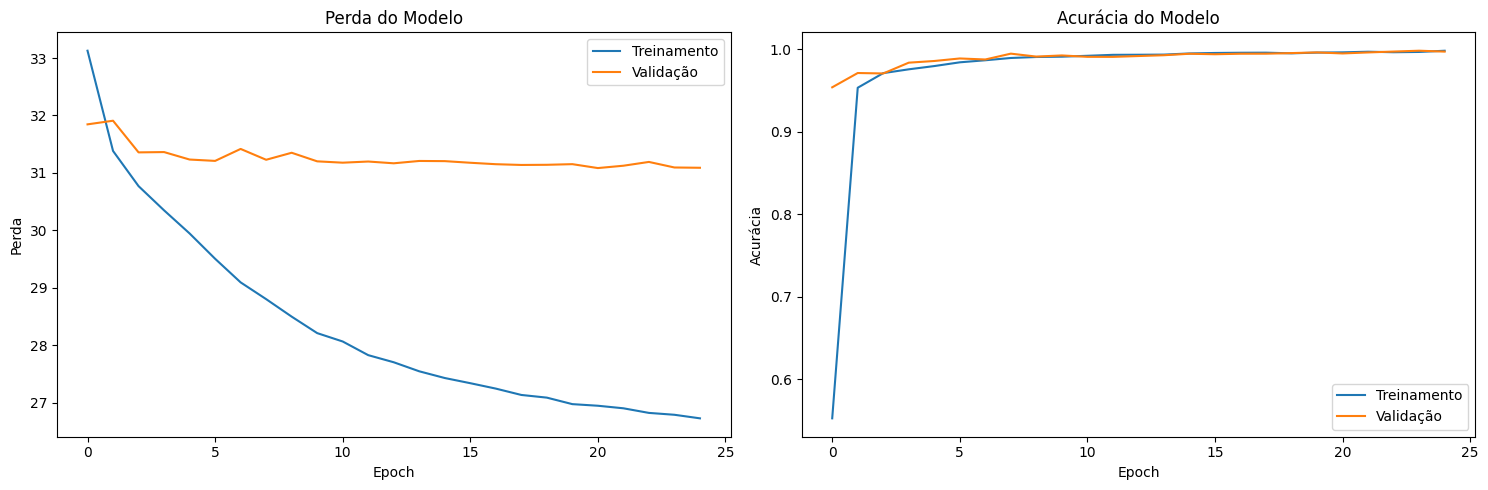

In [337]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Lista de métricas para plotar
    metrics = ['loss', 'accuracy']
    if 'val_loss' in history.history:
        metrics.extend(['val_loss', 'val_accuracy'])

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot de perda
    axs[0].plot(history.history['loss'], label='Treinamento')
    if 'val_loss' in history.history:
        axs[0].plot(history.history['val_loss'], label='Validação')
    axs[0].set_title('Perda do Modelo')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Perda')
    axs[0].legend()

    # Plot de acurácia
    axs[1].plot(history.history['accuracy'], label='Treinamento')
    if 'val_accuracy' in history.history:
        axs[1].plot(history.history['val_accuracy'], label='Validação')
    axs[1].set_title('Acurácia do Modelo')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Acurácia')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [339]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
import numpy as np

import tensorflow as tf
import tensorflow.keras.backend as K

def simple_segmentation_loss(y_true, y_pred):
    def dice_loss(y_true, y_pred, smooth=1):
        intersection = K.sum(y_true * y_pred, axis=[1,2,3])
        union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
        dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
        return 1 - dice

    def binary_crossentropy(y_true, y_pred):
        return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

    # Combine Dice Loss and Binary Cross-Entropy
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * binary_crossentropy(y_true, y_pred)

# Load the VGG16 model
vgg16_path = '/content/drive/MyDrive/VGG_TransferLearning_V2TOP_SEMOVERFITTING.h5'
try:
    vgg16 = load_model(vgg16_path, compile=False)
    print("VGG16 model loaded successfully")
    print("VGG16 input shape:", vgg16.input_shape)
    print("VGG16 output shape:", vgg16.output_shape)
except Exception as e:
    print(f"Error loading VGG16 model: {e}")
    raise

def simplified_unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    vgg16 = load_model(vgg16_path, compile=False)

    # Encoder (use VGG16 layers)
    x = vgg16.get_layer('block1_conv1')(inputs)
    x = vgg16.get_layer('block1_conv2')(x)
    skip1 = x
    x = MaxPooling2D()(x)

    x = vgg16.get_layer('block2_conv1')(x)
    x = vgg16.get_layer('block2_conv2')(x)
    skip2 = x
    x = MaxPooling2D()(x)

    x = vgg16.get_layer('block3_conv1')(x)
    x = vgg16.get_layer('block3_conv2')(x)
    x = vgg16.get_layer('block3_conv3')(x)
    skip3 = x
    x = MaxPooling2D()(x)

    x = vgg16.get_layer('block4_conv1')(x)
    x = vgg16.get_layer('block4_conv2')(x)
    x = vgg16.get_layer('block4_conv3')(x)
    skip4 = x
    x = MaxPooling2D()(x)

    x = vgg16.get_layer('block5_conv1')(x)
    x = vgg16.get_layer('block5_conv2')(x)
    x = vgg16.get_layer('block5_conv3')(x)

    # Decoder
    x = UpSampling2D()(x)
    x = concatenate([x, skip4])
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)

    x = UpSampling2D()(x)
    x = concatenate([x, skip3])
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)

    x = UpSampling2D()(x)
    x = concatenate([x, skip2])
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)

    x = UpSampling2D()(x)
    x = concatenate([x, skip1])
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Dropout(0.1)(x)

    outputs = Conv2D(3, 1, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = simplified_unet()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=simple_segmentation_loss,
              metrics=['accuracy'])

model.summary()

# Verify and preprocess data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('unet_boi_olhos_vgg16_v1.2.keras', save_best_only=True, monitor='val_loss')
    ]
)

model.save('unet_boi_olhos_vgg16_v1.2.h5')
print("Model saved successfully")

VGG16 model loaded successfully
VGG16 input shape: (None, 128, 128, 3)
VGG16 output shape: (None, 128, 128, 3)


Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_75            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 128, 128, 64)   │          1,792 │ input_layer_75[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 128, 128, 64)   │         36,928 │ block1_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_214         │ (None, 64, 64, 64)     │              0 │ block1_conv2[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_214[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 64, 64, 128)    │        147,584 │ block2_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_215         │ (None, 32, 32, 128)    │              0 │ block2_conv2[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_215[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_216         │ (None, 16, 16, 256)    │              0 │ block3_conv3[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_216[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv1[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv2[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_217         │ (None, 8, 8, 512)      │              0 │ block4_conv3[1][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ max_pooling2d_217[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block5_conv1[1][0]     │
├──────────────────────

 Total params: 24,891,267 (94.95 MB)

 Trainable params: 24,891,267 (94.95 MB)

 Non-trainable params: 0 (0.00 B)

X_train shape: (7943, 128, 128, 3)
y_train shape: (7943, 128, 128, 3)
Epoch 1/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.4705 - loss: 34.7303 - val_accuracy: 0.9934 - val_loss: 32.3235 - learning_rate: 1.0000e-04
Epoch 2/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9796 - loss: 31.6273 - val_accuracy: 0.9965 - val_loss: 31.5973 - learning_rate: 1.0000e-04
Epoch 3/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9898 - loss: 30.9290 - val_accuracy: 0.9984 - val_loss: 31.3534 - learning_rate: 1.0000e-04
Epoch 4/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9922 - loss: 30.5199 - val_accuracy: 0.9982 - val_loss: 31.3367 - learning_rate: 1.0000e-04
Epoch 5/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9927 - loss: 29.9570 - val_accuracy: 0.9997 - val_loss: 31.2364 - learning_rate: 1.0000e-04


Model saved successfully


In [342]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

# Definindo as funções personalizadas
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * tf.keras.losses.mean_squared_error(y_true, y_pred)

# Definindo a função de perda personalizada 'loss'
def loss(y_true, y_pred):
    return combined_loss(y_true, y_pred)

y_pred = model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


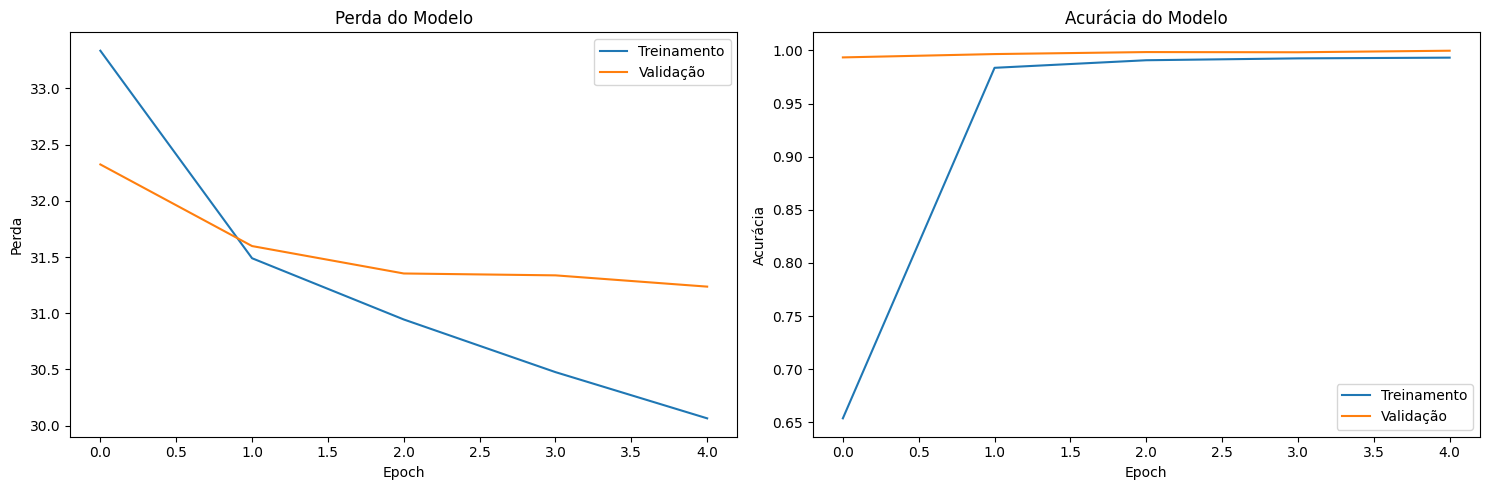

In [343]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Lista de métricas para plotar
    metrics = ['loss', 'accuracy']
    if 'val_loss' in history.history:
        metrics.extend(['val_loss', 'val_accuracy'])

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot de perda
    axs[0].plot(history.history['loss'], label='Treinamento')
    if 'val_loss' in history.history:
        axs[0].plot(history.history['val_loss'], label='Validação')
    axs[0].set_title('Perda do Modelo')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Perda')
    axs[0].legend()

    # Plot de acurácia
    axs[1].plot(history.history['accuracy'], label='Treinamento')
    if 'val_accuracy' in history.history:
        axs[1].plot(history.history['val_accuracy'], label='Validação')
    axs[1].set_title('Acurácia do Modelo')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Acurácia')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

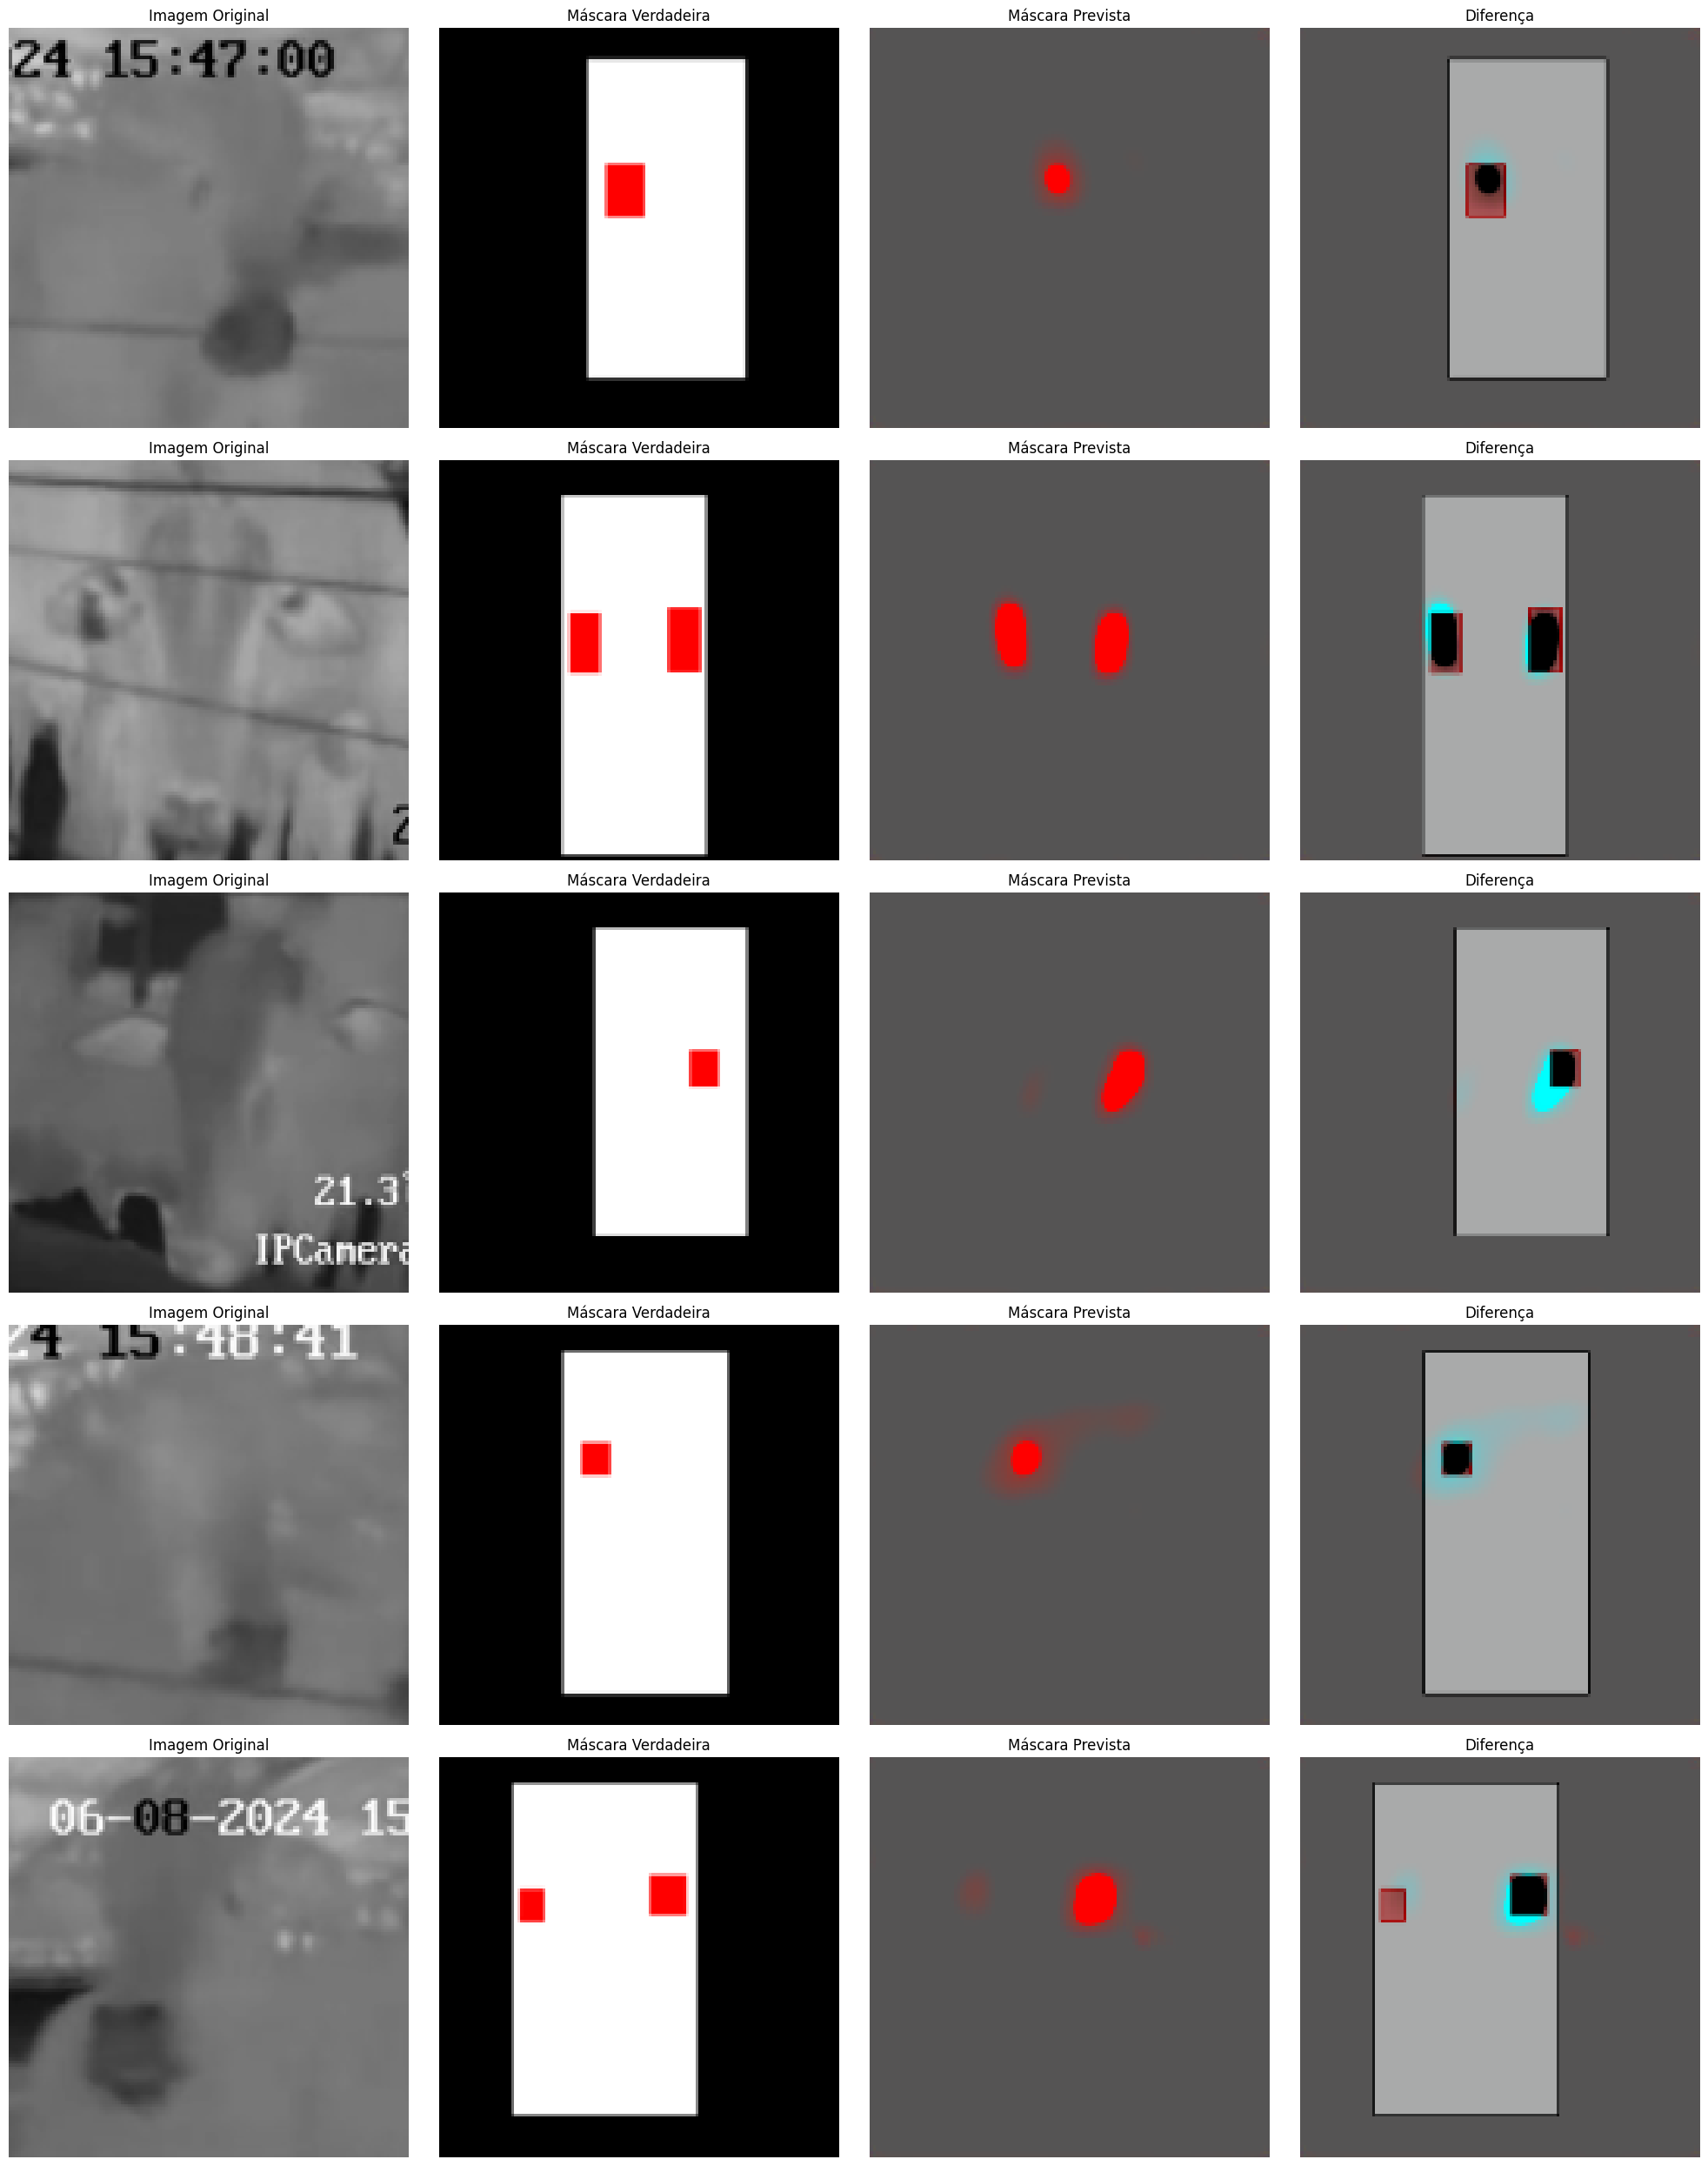

In [344]:
# Função para visualizar as imagens
def visualize_results(X, y_true, y_pred, num_samples=5):
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))

    for i in range(num_samples):

        # Imagem original
        axes[i, 0].imshow(np.squeeze(X[i]), cmap='viridis')
        axes[i, 0].set_title('Imagem Original')
        axes[i, 0].axis('off')

        # Máscara verdadeira
        axes[i, 1].imshow(np.squeeze(y_true[i]), cmap='viridis')
        axes[i, 1].set_title('Máscara Verdadeira')
        axes[i, 1].axis('off')

        # Máscara prevista
        axes[i, 2].imshow(np.squeeze(y_pred[i]), cmap='viridis')
        axes[i, 2].set_title('Máscara Prevista')
        axes[i, 2].axis('off')

        # Diferença entre verdadeira e prevista
        diff = np.abs(np.squeeze(y_true[i]) - np.squeeze(y_pred[i]))
        axes[i, 3].imshow(diff, cmap='hot')
        axes[i, 3].set_title('Diferença')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Visualizar os resultados
visualize_results(X_test, y_test, y_pred)

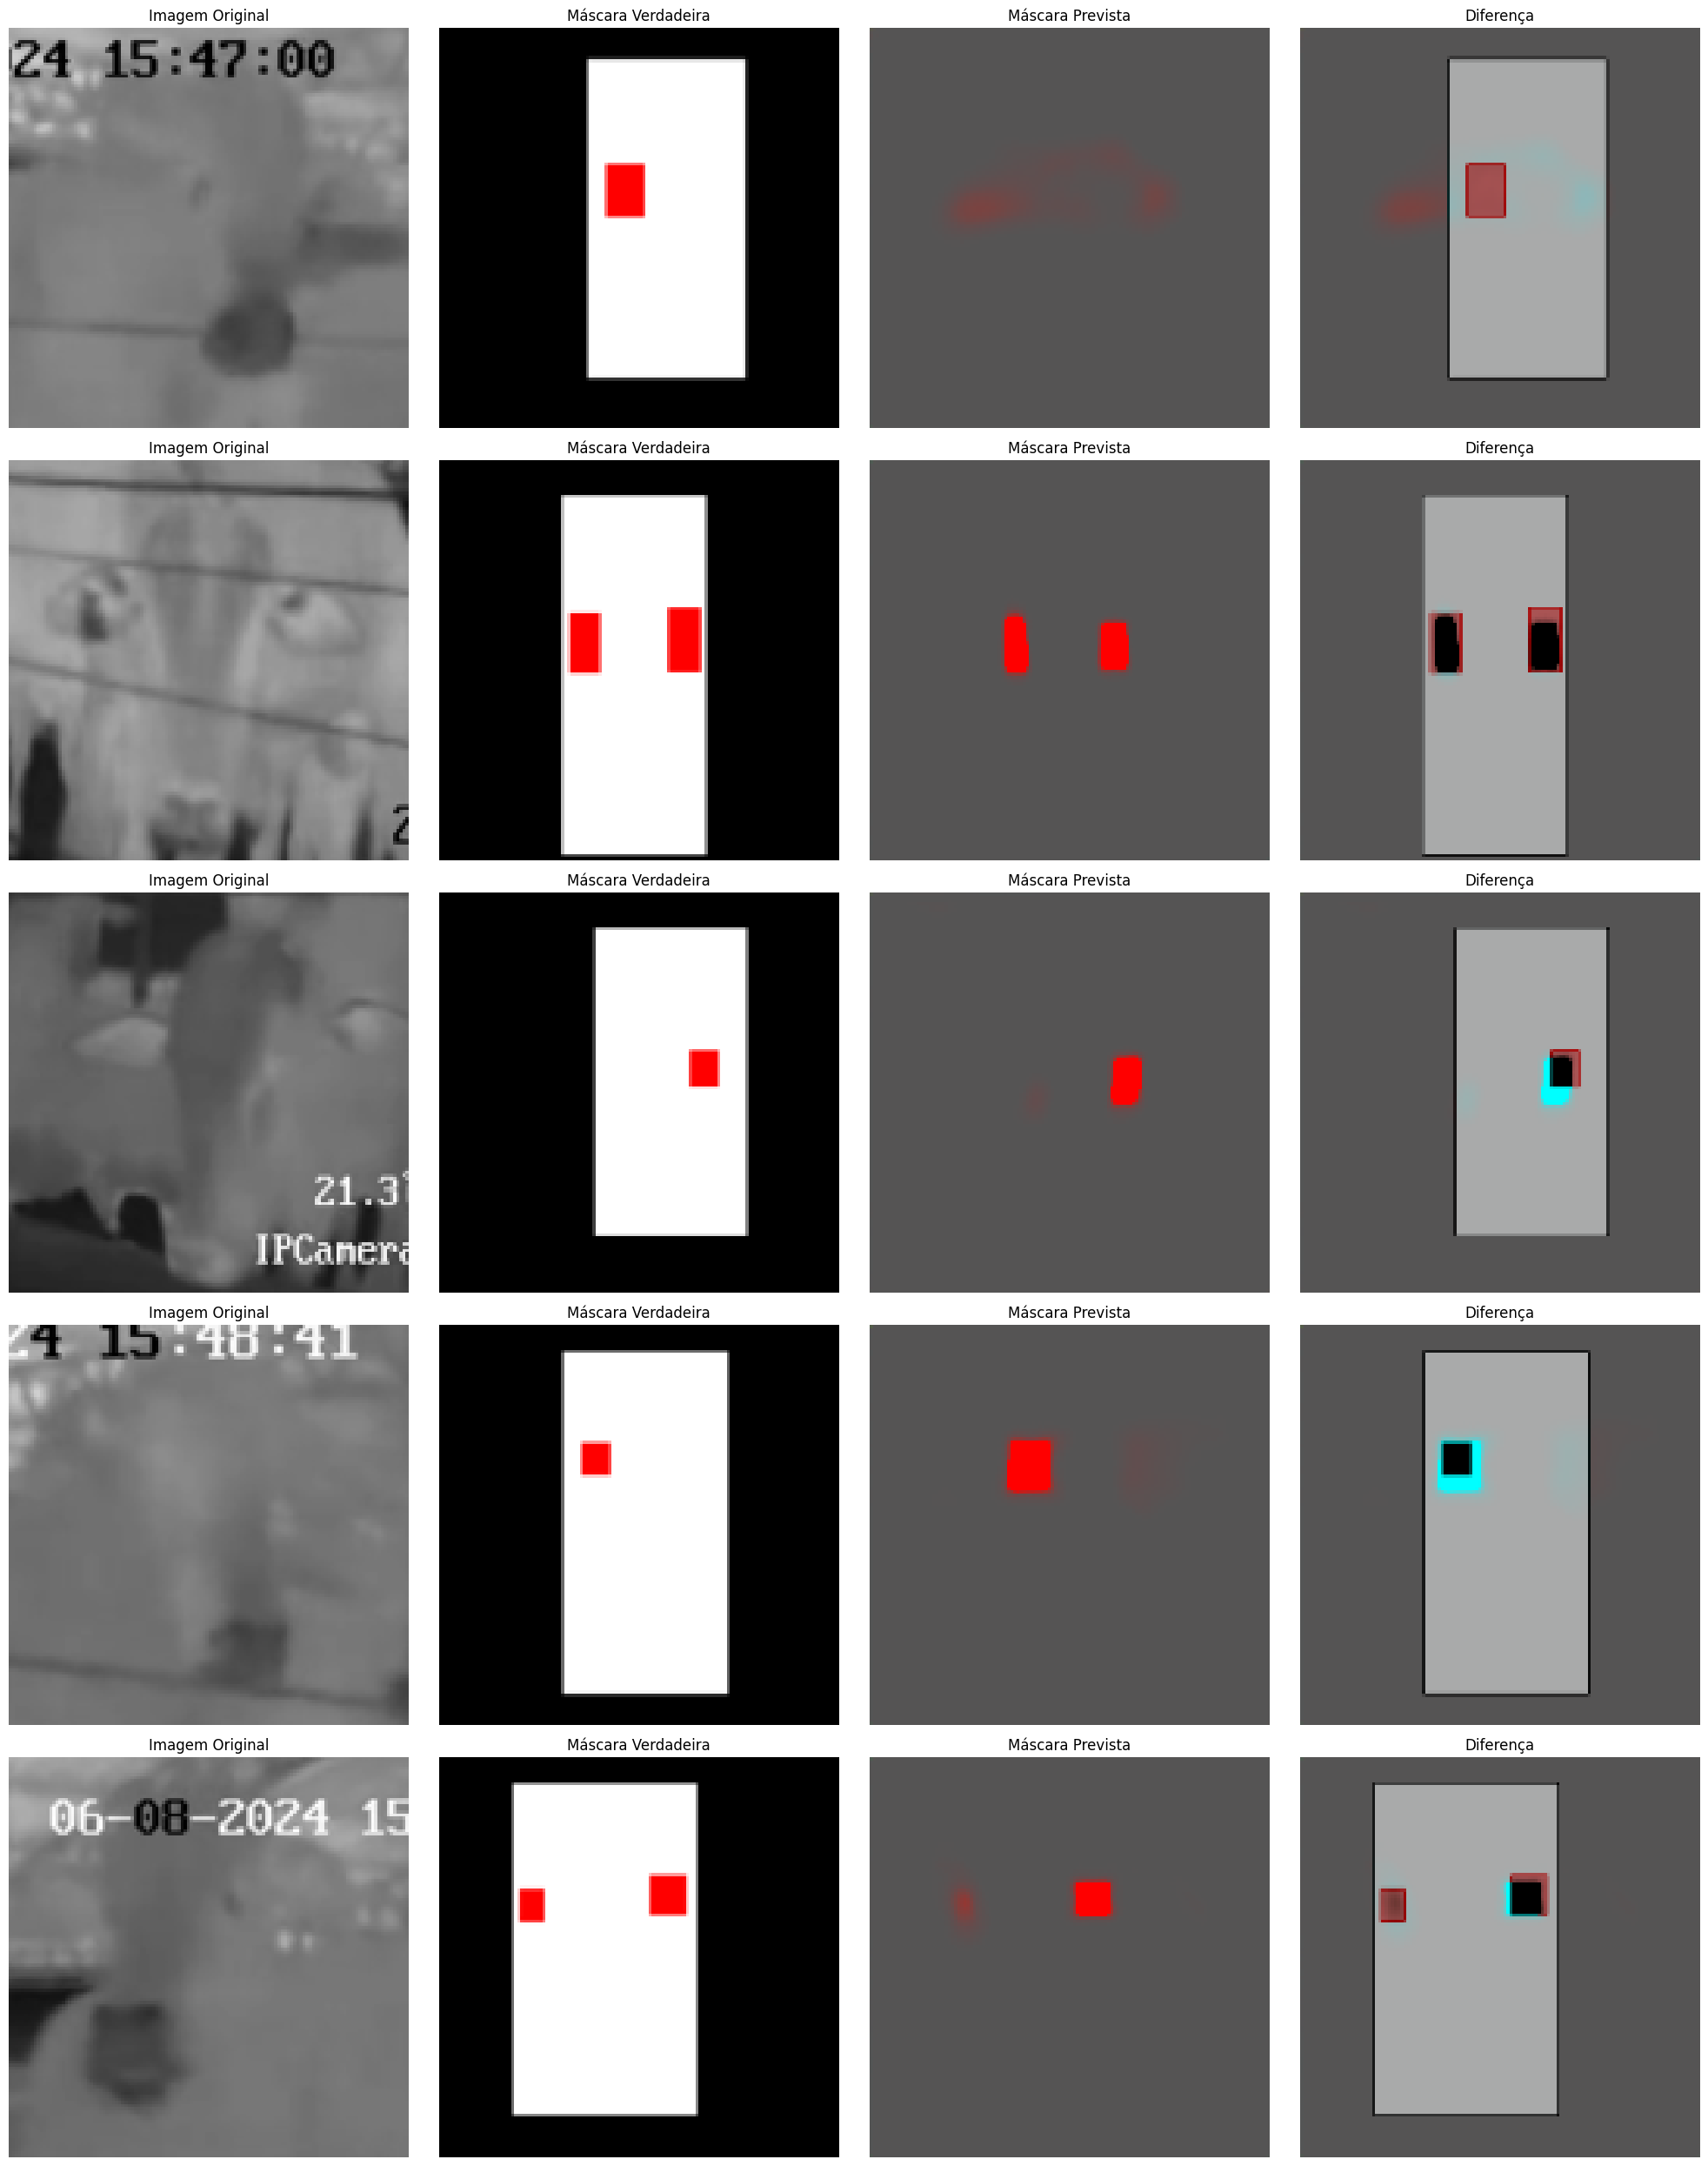

In [338]:
# Função para visualizar as imagens
def visualize_results(X, y_true, y_pred, num_samples=5):
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))

    for i in range(num_samples):

        # Imagem original
        axes[i, 0].imshow(np.squeeze(X[i]), cmap='viridis')
        axes[i, 0].set_title('Imagem Original')
        axes[i, 0].axis('off')

        # Máscara verdadeira
        axes[i, 1].imshow(np.squeeze(y_true[i]), cmap='viridis')
        axes[i, 1].set_title('Máscara Verdadeira')
        axes[i, 1].axis('off')

        # Máscara prevista
        axes[i, 2].imshow(np.squeeze(y_pred[i]), cmap='viridis')
        axes[i, 2].set_title('Máscara Prevista')
        axes[i, 2].axis('off')

        # Diferença entre verdadeira e prevista
        diff = np.abs(np.squeeze(y_true[i]) - np.squeeze(y_pred[i]))
        axes[i, 3].imshow(diff, cmap='hot')
        axes[i, 3].set_title('Diferença')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Visualizar os resultados
visualize_results(X_test, y_test, y_pred)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation, Conv2DTranspose
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

def cluster_aware_focal_loss(alpha=0.25, gamma=2, spatial_weight=1):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        focal_loss = -alpha * K.pow(1 - y_pred, gamma) * y_true * K.log(y_pred) - \
                     (1 - alpha) * K.pow(y_pred, gamma) * (1 - y_true) * K.log(1 - y_pred)
        focal_loss = K.sum(focal_loss, axis=-1)

        height, width = K.int_shape(y_pred)[1:3]
        y_coords, x_coords = tf.meshgrid(tf.range(height, dtype=tf.float32),
                                         tf.range(width, dtype=tf.float32),
                                         indexing='ij')
        coords = tf.stack([y_coords, x_coords], axis=-1)

        def calculate_centroid(mask):
            total_mass = K.sum(mask, axis=[1, 2]) + epsilon
            weighted_y = K.sum(y_coords[..., tf.newaxis] * mask, axis=[1, 2]) / total_mass
            weighted_x = K.sum(x_coords[..., tf.newaxis] * mask, axis=[1, 2]) / total_mass
            return tf.stack([weighted_y, weighted_x], axis=-1)

        true_centroids = calculate_centroid(y_true)
        pred_centroids = calculate_centroid(y_pred)

        centroid_distance = K.sqrt(K.sum(K.square(true_centroids - pred_centroids), axis=-1))

        pixel_distances = K.sqrt(K.sum(K.square(coords[..., tf.newaxis, :] - true_centroids[:, tf.newaxis, tf.newaxis, :]), axis=-1))
        distance_penalty = K.sum(pixel_distances * K.abs(y_true - y_pred), axis=-1)

        total_loss = focal_loss + spatial_weight * distance_penalty

        return K.mean(total_loss)

    return loss

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, 3, padding='same', use_bias=False)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def tmd_unet_vgg16(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Load pre-trained VGG16 model with frozen weights
    vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

    for layer in vgg16.layers:
        layer.trainable = False

    # Encoder (downsampling path)
    block1_conv2 = vgg16.get_layer('block1_conv2').output
    block2_conv2 = vgg16.get_layer('block2_conv2').output
    block3_conv3 = vgg16.get_layer('block3_conv3').output
    block4_conv3 = vgg16.get_layer('block4_conv3').output
    block5_conv3 = vgg16.get_layer('block5_conv3').output

    # Bridge
    bridge = conv_block(block5_conv3, 512)

    # Decoder (Upsampling) with transposed convolutions and multiscale features
    up6 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(bridge)
    up6 = concatenate([up6, block4_conv3])
    conv6 = conv_block(up6, 256)

    up7 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, block3_conv3])
    conv7 = conv_block(up7, 128)

    up8 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, block2_conv2])
    conv8 = conv_block(up8, 64)

    up9 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, block1_conv2])
    conv9 = conv_block(up9, 32)

    # Multiscale feature fusion
    multiscale_1 = Conv2D(32, 1, activation='relu')(block1_conv2)
    multiscale_2 = Conv2D(32, 1, activation='relu')(UpSampling2D(size=(2, 2))(block2_conv2))
    multiscale_3 = Conv2D(32, 1, activation='relu')(UpSampling2D(size=(4, 4))(block3_conv3))
    multiscale_4 = Conv2D(32, 1, activation='relu')(UpSampling2D(size=(8, 8))(block4_conv3))

    multiscale_fusion = concatenate([conv9, multiscale_1, multiscale_2, multiscale_3, multiscale_4])

    # Final convolution
    outputs = Conv2D(3, 1, activation='softmax')(multiscale_fusion)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile the model
model = tmd_unet_vgg16()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=cluster_aware_focal_loss(),
              metrics=['accuracy'])

model.summary()

# Verify data shapes
print("X_train_final shape:", X_train_augmented.shape)
print("y_train_final shape:", y_train_augmented.shape)

# Train the model
history = model.fit(
    X_train_augmented, y_train_augmented,
    batch_size=32,
    epochs=2,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-7, mode='max'),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max'),
        tf.keras.callbacks.ModelCheckpoint('tmd_unet_boi_olhos_vgg16_v1.0.h5', save_best_only=True, monitor='val_accuracy', mode='max')
    ]
)

model.save('tmd_unet_boi_olhos_vgg16_v1.0.h5')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

# Definindo as funções personalizadas
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * tf.keras.losses.mean_squared_error(y_true, y_pred)

# Definindo a função de perda personalizada 'loss'
def loss(y_true, y_pred):
    return combined_loss(y_true, y_pred)

# Carregar o modelo treinado
model = load_model('tmd_unet_boi_olhos_vgg16_v1.h5', custom_objects={
    'dice_coefficient': dice_coefficient,
    'dice_loss': dice_loss,
    'combined_loss': combined_loss,
    'loss': loss  # Adicionando a função de perda personalizada
})

# Assumindo que X_test e y_test são seus dados de teste
# Fazer previsões
y_pred = model.predict(X_test_transformed)

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Lista de métricas para plotar
    metrics = ['loss', 'accuracy']
    if 'val_loss' in history.history:
        metrics.extend(['val_loss', 'val_accuracy'])

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot de perda
    axs[0].plot(history.history['loss'], label='Treinamento')
    if 'val_loss' in history.history:
        axs[0].plot(history.history['val_loss'], label='Validação')
    axs[0].set_title('Perda do Modelo')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Perda')
    axs[0].legend()

    # Plot de acurácia
    axs[1].plot(history.history['accuracy'], label='Treinamento')
    if 'val_accuracy' in history.history:
        axs[1].plot(history.history['val_accuracy'], label='Validação')
    axs[1].set_title('Acurácia do Modelo')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Acurácia')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Função para visualizar as imagens
def visualize_results(X, y_true, y_pred, num_samples=5):
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))

    for i in range(num_samples):

        # Imagem original
        axes[i, 0].imshow(np.squeeze(X[i]), cmap='viridis')
        axes[i, 0].set_title('Imagem Original')
        axes[i, 0].axis('off')

        # Máscara verdadeira
        axes[i, 1].imshow(np.squeeze(y_true[i]), cmap='viridis')
        axes[i, 1].set_title('Máscara Verdadeira')
        axes[i, 1].axis('off')

        # Máscara prevista
        axes[i, 2].imshow(np.squeeze(y_pred[i]), cmap='viridis')
        axes[i, 2].set_title('Máscara Prevista')
        axes[i, 2].axis('off')

        # Diferença entre verdadeira e prevista
        diff = np.abs(np.squeeze(y_true[i]) - np.squeeze(y_pred[i]))
        axes[i, 3].imshow(diff, cmap='hot')
        axes[i, 3].set_title('Diferença')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Visualizar os resultados
visualize_results(X_test, y_test, y_pred)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation, Add, Multiply
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

def cluster_aware_focal_loss(alpha=0.25, gamma=2, spatial_weight=1):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        focal_loss = -alpha * K.pow(1 - y_pred, gamma) * y_true * K.log(y_pred) - \
                     (1 - alpha) * K.pow(y_pred, gamma) * (1 - y_true) * K.log(1 - y_pred)
        focal_loss = K.sum(focal_loss, axis=-1)

        height, width = K.int_shape(y_pred)[1:3]
        y_coords, x_coords = tf.meshgrid(tf.range(height, dtype=tf.float32),
                                         tf.range(width, dtype=tf.float32),
                                         indexing='ij')
        coords = tf.stack([y_coords, x_coords], axis=-1)

        def calculate_centroid(mask):
            total_mass = K.sum(mask, axis=[1, 2]) + epsilon
            weighted_y = K.sum(y_coords[..., tf.newaxis] * mask, axis=[1, 2]) / total_mass
            weighted_x = K.sum(x_coords[..., tf.newaxis] * mask, axis=[1, 2]) / total_mass
            return tf.stack([weighted_y, weighted_x], axis=-1)

        true_centroids = calculate_centroid(y_true)
        pred_centroids = calculate_centroid(y_pred)

        centroid_distance = K.sqrt(K.sum(K.square(true_centroids - pred_centroids), axis=-1))

        pixel_distances = K.sqrt(K.sum(K.square(coords[..., tf.newaxis, :] - true_centroids[:, tf.newaxis, tf.newaxis, :]), axis=-1))
        distance_penalty = K.sum(pixel_distances * K.abs(y_true - y_pred), axis=-1)

        total_loss = focal_loss + spatial_weight * distance_penalty

        return K.mean(total_loss)

    return loss

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, 3, padding='same', use_bias=False)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, 1, use_bias=False)(x)
    phi_g = Conv2D(inter_channel, 1, use_bias=False)(g)

    f = Activation('relu')(Add()([theta_x, phi_g]))
    psi_f = Conv2D(1, 1, use_bias=False)(f)

    rate = Activation('sigmoid')(psi_f)
    att_x = Multiply()([x, rate])

    return att_x

def pde_block(input_tensor, num_filters):
    conv = Conv2D(num_filters, 3, padding='same', use_bias=False)(input_tensor)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)

    diff_x = Conv2D(num_filters, 3, padding='same', use_bias=False)(conv)
    diff_y = Conv2D(num_filters, 3, padding='same', use_bias=False)(conv)

    out = Add()([diff_x, diff_y, conv])
    out = BatchNormalization()(out)
    out = Activation('relu')(out)

    return out

def pdeatt_unet_vgg16(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Load pre-trained VGG16 model with frozen weights
    vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

    for layer in vgg16.layers:
        layer.trainable = False

    # Encoder (downsampling path)
    block1_conv2 = vgg16.get_layer('block1_conv2').output
    block2_conv2 = vgg16.get_layer('block2_conv2').output
    block3_conv3 = vgg16.get_layer('block3_conv3').output
    block4_conv3 = vgg16.get_layer('block4_conv3').output
    block5_conv3 = vgg16.get_layer('block5_conv3').output

    # Bridge
    bridge = pde_block(block5_conv3, 512)

    # Decoder (Upsampling) with attention and PDE blocks
    up6 = UpSampling2D(size=(2, 2))(bridge)
    att6 = attention_block(block4_conv3, up6, 256)
    merge6 = concatenate([up6, att6])
    conv6 = pde_block(merge6, 256)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    att7 = attention_block(block3_conv3, up7, 128)
    merge7 = concatenate([up7, att7])
    conv7 = pde_block(merge7, 128)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    att8 = attention_block(block2_conv2, up8, 64)
    merge8 = concatenate([up8, att8])
    conv8 = pde_block(merge8, 64)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    att9 = attention_block(block1_conv2, up9, 32)
    merge9 = concatenate([up9, att9])
    conv9 = pde_block(merge9, 32)

    # Final convolution
    outputs = Conv2D(3, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile the model
model = pdeatt_unet_vgg16()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=cluster_aware_focal_loss(),
              metrics=['accuracy'])

model.summary()

# Verify data shapes
print("X_train_final shape:", X_train_augmented.shape)
print("y_train_final shape:", y_train_augmented.shape)

# Train the model
history = model.fit(
    X_train_augmented, y_train_augmented,
    batch_size=32,
    epochs=2,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-7, mode='max'),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max'),
        tf.keras.callbacks.ModelCheckpoint('pdeatt_unet_boi_olhos_vgg16_v1.0.h5', save_best_only=True, monitor='val_accuracy', mode='max')
    ]
)

model.save('pdeatt_unet_boi_olhos_vgg16_v1.0.h5')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

# Definindo as funções personalizadas
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * tf.keras.losses.mean_squared_error(y_true, y_pred)

# Definindo a função de perda personalizada 'loss'
def loss(y_true, y_pred):
    return combined_loss(y_true, y_pred)

# Carregar o modelo treinado
model = load_model('tmd_unet_boi_olhos_vgg16_v1.h5', custom_objects={
    'dice_coefficient': dice_coefficient,
    'dice_loss': dice_loss,
    'combined_loss': combined_loss,
    'loss': loss  # Adicionando a função de perda personalizada
})

# Assumindo que X_test e y_test são seus dados de teste
# Fazer previsões
y_pred = model.predict(X_test_transformed)

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Lista de métricas para plotar
    metrics = ['loss', 'accuracy']
    if 'val_loss' in history.history:
        metrics.extend(['val_loss', 'val_accuracy'])

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot de perda
    axs[0].plot(history.history['loss'], label='Treinamento')
    if 'val_loss' in history.history:
        axs[0].plot(history.history['val_loss'], label='Validação')
    axs[0].set_title('Perda do Modelo')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Perda')
    axs[0].legend()

    # Plot de acurácia
    axs[1].plot(history.history['accuracy'], label='Treinamento')
    if 'val_accuracy' in history.history:
        axs[1].plot(history.history['val_accuracy'], label='Validação')
    axs[1].set_title('Acurácia do Modelo')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Acurácia')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Função para visualizar as imagens
def visualize_results(X, y_true, y_pred, num_samples=5):
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))

    for i in range(num_samples):

        # Imagem original
        axes[i, 0].imshow(np.squeeze(X[i]), cmap='viridis')
        axes[i, 0].set_title('Imagem Original')
        axes[i, 0].axis('off')

        # Máscara verdadeira
        axes[i, 1].imshow(np.squeeze(y_true[i]), cmap='viridis')
        axes[i, 1].set_title('Máscara Verdadeira')
        axes[i, 1].axis('off')

        # Máscara prevista
        axes[i, 2].imshow(np.squeeze(y_pred[i]), cmap='viridis')
        axes[i, 2].set_title('Máscara Prevista')
        axes[i, 2].axis('off')

        # Diferença entre verdadeira e prevista
        diff = np.abs(np.squeeze(y_true[i]) - np.squeeze(y_pred[i]))
        axes[i, 3].imshow(diff, cmap='hot')
        axes[i, 3].set_title('Diferença')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Visualizar os resultados
visualize_results(X_test, y_test, y_pred)